# Data

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np

In [43]:
# https://www.coingecko.com/api/documentations/v3#/coins/get_coins__id__market_chart
params = {
    "coin":"nexo",
    "vs_currency":"eur",
    "days":60,
    "interval":"daily"
}

base_url = "https://api.coingecko.com/api/v3/coins/"
param_url = "{coin}/market_chart?vs_currency={vs_currency}&days={days}&interval={interval}"
url = base_url + param_url.format(**params)

In [44]:
page = requests.get(url)    

In [45]:
if page.status_code == 200:
    prices = [i[1] for i in page.json()["prices"]]
    dates = [datetime.date.fromtimestamp(i[0]/1000) for i in page.json()["prices"]]

In [62]:
df = pd.DataFrame({"dates":dates, "prices":prices})
df.index = df.dates
df.drop("dates", axis=1,inplace=True)

df.head()


,prices
dates,
2021-08-22,1.609613
2021-08-23,1.645399
2021-08-24,1.671302
2021-08-25,1.602531
2021-08-26,1.629510


# Simple Linear Regression

In [47]:
# Time-step features (time dummy)
df['time'] = np.arange(len(df.index))
df.head()

,prices,time
dates,,
2021-08-22,1.609613,0
2021-08-23,1.645399,1
2021-08-24,1.671302,2
2021-08-25,1.602531,3
2021-08-26,1.629510,4


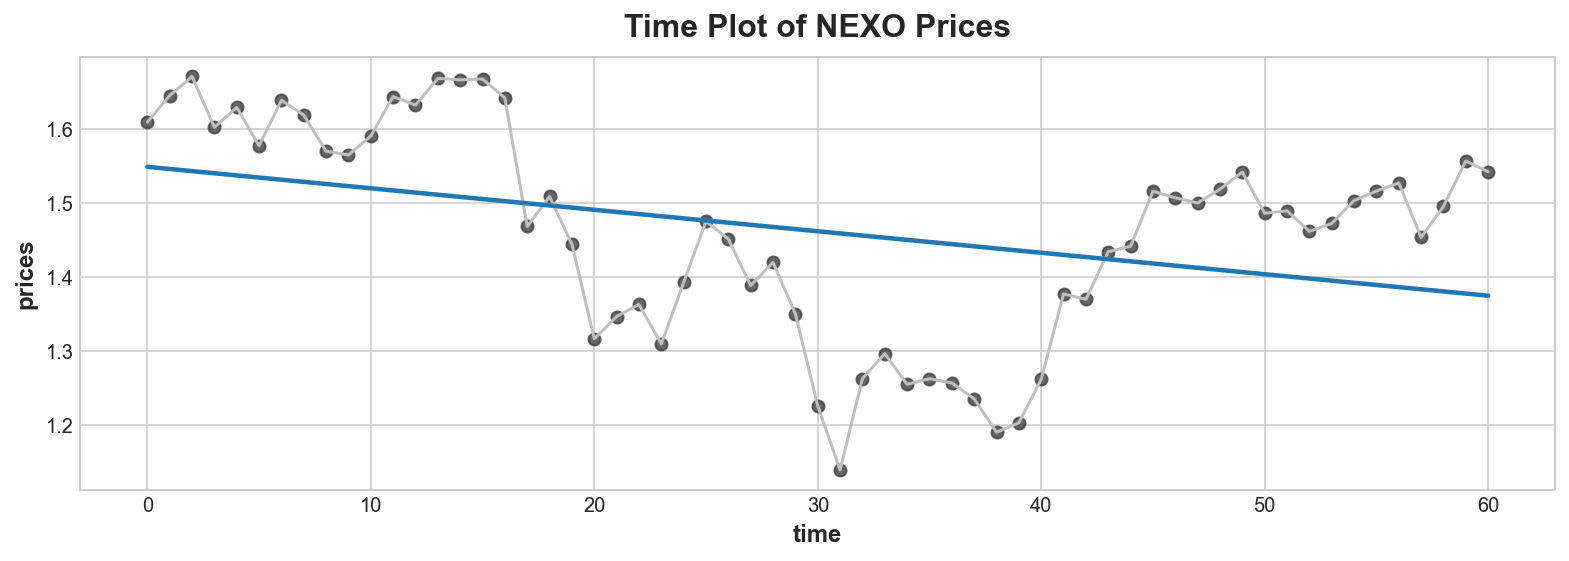

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('time', 'prices', data=df, color='0.75')
ax = sns.regplot(x='time', y='prices', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of NEXO Prices');

In [49]:
# Lag Features
df['lag_1'] = df['prices'].shift(1)
#df = df.reindex(columns=['prices', 'lag_1'])

df.head()

,prices,time,lag_1
dates,,,
2021-08-22,1.609613,0,NaN
2021-08-23,1.645399,1,1.609613
2021-08-24,1.671302,2,1.645399
2021-08-25,1.602531,3,1.671302
2021-08-26,1.629510,4,1.602531


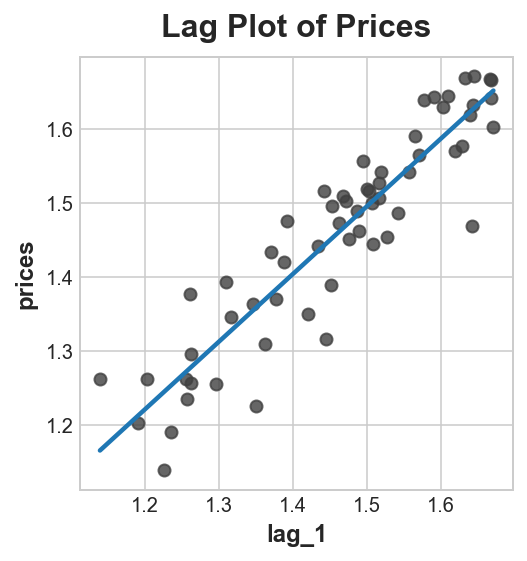

In [50]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='prices', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Prices');

In [51]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [52]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'prices']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [53]:
weight = model.coef_[0]
bias = model.intercept_

Our simple time step model looks like this:

In [54]:
print(f"Price = {weight} * Time + {bias}")

Price = -0.0029031964576152628 * Time + 1.5492362914177942


Plotted:

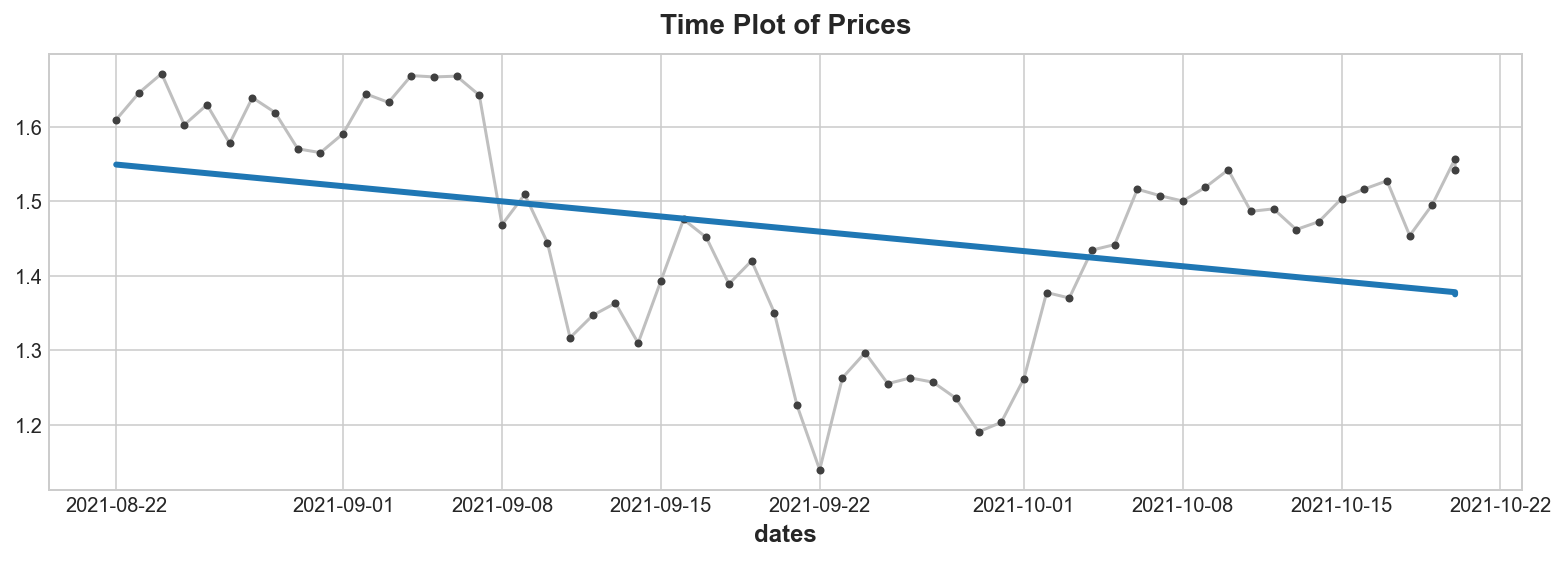

In [55]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Prices');

In [56]:
X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'prices']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

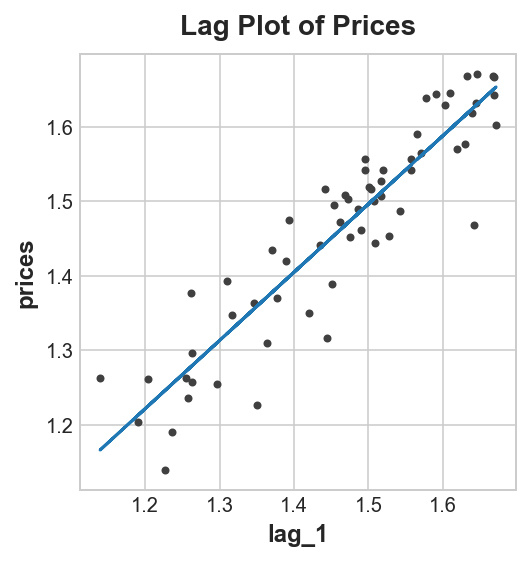

In [57]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('prices')
ax.set_xlabel('lag_1')
ax.set_title('Lag Plot of Prices');

In [59]:
weight = model.coef_[0]
bias = model.intercept_

Our simple lag model looks like this:

In [60]:
print(f"Price = {weight} * Lag + {bias}")

Price = 0.9168608446360706 * Lag + 0.12129668034250529


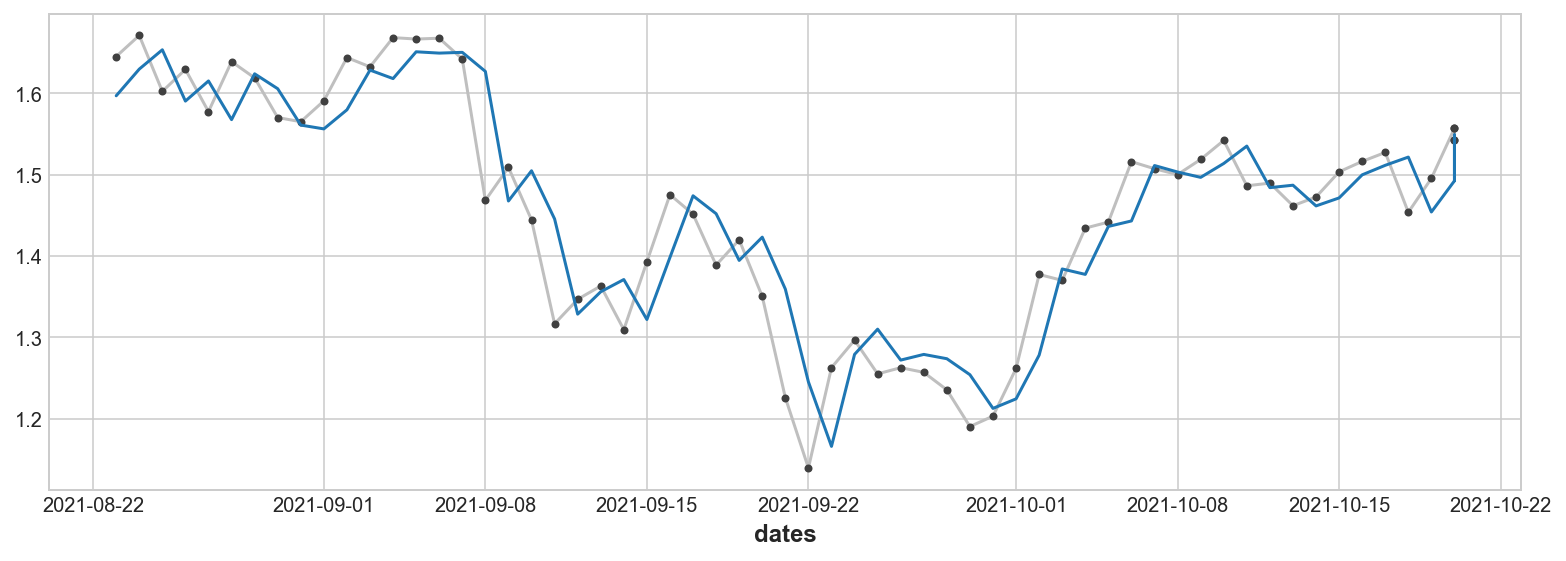

In [58]:
ax = y.plot(**plot_params)
ax = y_pred.plot()